# Search for a subset of data suitable for a test set

We want to find some set of items that were all rated by some subset of users. This would give us a test subset with full feedback.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import surprise as sp

from data_loading import get_movielens_data

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
PROJECT_DIR = '.'

In [9]:
def print_mean_rewards(reward_list, actions):
    watched_list_series = (
        reward_list.groupby("user_id")["item_id"].agg(set=set).set
    )
    user_id_to_watched_list_index = {
        uid: ind for ind, uid in enumerate(watched_list_series.index)
    }
    reward_matrix = np.zeros((len(user_id_to_watched_list_index), len(actions)))
    for uid, ind in user_id_to_watched_list_index.items():
        watched_list = watched_list_series.iloc[ind]
        watched_indices = [i for i in range(len(actions)) if actions[i] in watched_list]
        # Binary vector of rewards for each arm.
        reward_matrix[ind, watched_indices] = 1

    mean_rew = reward_matrix.mean(axis=0)

    print(f"Reward of best 50 arms: {np.sort(mean_rew)[::-1][:50]}")
    print(f"Sum of rewards:\t {mean_rew.sum()}")

In [10]:
AMAZON_NUMBER_OF_ACTIONS = 400
THRESHOLD = None

def create_actions_users_and_rewards(ratings_df):
    """Preprocess the original dataframe to extract actions, users and rewards from it.

    1. Extract top AMAZON_NUMBER_OF_ACTIONS items from the data (sort by number of ratings).
    2. Then extract users which rated those extracted items. This way, for every user at least one arm
    will have reward 1 later.
    3. Create rewards from ratings by considering rating > 3.0 being reward 1. Then only save user-item-reward 
    triplets
    for rewards equal to 1. This way we can filter by user during evaluation and if item is there reward is 1.
    """
    # Choose a less sparse subset of data with a length of 1 year.
    YEARS_BEHIND = 5.8
    max_ts = ratings_df.timestamp.max()
    start_time = max_ts - 3600 * 24 * 365 * YEARS_BEHIND
    end_time = max_ts - 3600 * 24 * 365 * (YEARS_BEHIND-0.5)
    print(f"Start time: {datetime.fromtimestamp(start_time)}")
    print(f"End time: {datetime.fromtimestamp(end_time)}")
    ratings_df = ratings_df[ratings_df.timestamp > start_time]
    ratings_df = ratings_df[ratings_df.timestamp < end_time]

    actions = ratings_df.groupby("item_id").size().sort_values(ascending=False)[:AMAZON_NUMBER_OF_ACTIONS]
    actions = list(actions.index)

    # Only consider users that have watched some movies from the considered actions.
    top_ratings = ratings_df[ratings_df["item_id"].isin(actions)]
    top_ratings = top_ratings.sort_values("timestamp", ascending=1)
    user_stream = top_ratings[["user_id", "timestamp"]]

    NUM_UNIQUE_USERS = 7000
    top_users = list(top_ratings.groupby('user_id').size().sort_values(ascending=False)[:NUM_UNIQUE_USERS].index)
    user_stream = user_stream[user_stream.user_id.isin(top_users)]
    user_stream = user_stream.drop_duplicates(subset=['user_id'])
    users = set(user_stream.user_id)

    user_stream = user_stream.sample(n=135000, replace=True, random_state=42)

    print(f"Experiments has {len(actions)} items,\n{len(user_stream)} users\nof which {len(users)} are unique.")

    top_ratings = top_ratings[top_ratings.user_id.isin(users)]

    if THRESHOLD is not None:
        top_ratings["reward"] = np.where(top_ratings["rating"] >= THRESHOLD, 1, 0)
    else:
        top_ratings["reward"] = np.where(top_ratings["rating"] >= 0.0, 1, 0)
    reward_list = top_ratings[["user_id", "item_id", "reward", "rating"]]
    reward_list = reward_list[reward_list['reward'] == 1]
    print_mean_rewards(reward_list, actions)
    # Used for NDCG computation
    ratings_list = top_ratings[["user_id", "item_id", "reward"]]
    return top_ratings, actions, user_stream, reward_list, ratings_list


In [16]:
jokes = sp.Dataset.load_builtin(name='jester')
for i, row in enumerate(jokes.raw_ratings):
    rowl = list(row)
    # Min rating is -10
    rowl[2] += 10
    jokes.raw_ratings[i] = tuple(rowl)

# svd_testset is basically zero, so that we can have all test_user_ids in the train set (fully labeled users)
trainset, testset = sp.model_selection.train_test_split(jokes, test_size=0.3)

In [17]:
print(f"User-rating matrix filled to total ratio: {trainset.n_ratings / (trainset.n_items * trainset.n_users)}")

User-rating matrix filled to total ratio: 0.15045771588668266


In [18]:
trainset.n_ratings, trainset.n_items, trainset.n_users

(1233007, 140, 58536)

In [19]:
len(testset)

528432

In [23]:
1233007 / 30000

41.100233333333335

## Getting train and test error for different regularization parameters

In [21]:
# reg_bus = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_bis = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_pus = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# reg_qis = [0.01, 0.05, 0.1, 0.5, 1.0, 10]
# grid = list(itertools.product(reg_bus, reg_bis, reg_pus, reg_qis))

grid = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 5, 10, 100]

train_rmses = np.zeros(len(grid))
test_rmses = np.zeros(len(grid))
trainset_to_test = trainset.build_testset()
for i, reg_params in enumerate(grid):
#     reg_bu, reg_bi, reg_pu, reg_qi = reg_params
    reg_all=reg_params
    print(f"Regularization parameter: {reg_params}")
    svd_start_ts = time.time()
#     svd = sp.SVD(
#         n_factors=100, n_epochs=250, random_state=42,
#         lr_all=0.01, reg_bu=reg_bu, reg_bi=reg_bi, reg_pu=reg_pu, reg_qi=reg_qi,        
#     )
    svd = sp.SVD(
        n_factors=150, n_epochs=250, random_state=42,
        lr_all=0.01, reg_all=reg_all   
    )
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

    
print(f"All test RMSEs: {test_rmses}")

Regularization parameter: 0.001
RMSE: 4.5449
RMSE: 5.3084
RMSE of SVD: 5.3083641410011
Took 113.38804626464844 seconds.
Regularization parameter: 0.005
RMSE: 4.5506
RMSE: 5.2993
RMSE of SVD: 5.2992590853344925
Took 117.6021180152893 seconds.
Regularization parameter: 0.01
RMSE: 4.5651
RMSE: 5.3056
RMSE of SVD: 5.305556106218803
Took 124.97093987464905 seconds.
Regularization parameter: 0.02
RMSE: 4.6057
RMSE: 5.3157
RMSE of SVD: 5.315726898071278
Took 117.8295829296112 seconds.
Regularization parameter: 0.05
RMSE: 4.7371
RMSE: 5.3303
RMSE of SVD: 5.330339014782138
Took 113.14555501937866 seconds.
Regularization parameter: 0.1
RMSE: 4.8567
RMSE: 5.3466
RMSE of SVD: 5.3466077478103
Took 119.71616315841675 seconds.
Regularization parameter: 0.2
RMSE: 5.0140
RMSE: 5.3648
RMSE of SVD: 5.364800854638717
Took 123.64467406272888 seconds.
Regularization parameter: 0.5
RMSE: 5.2881
RMSE: 5.3882
RMSE of SVD: 5.388194201878669
Took 114.03778505325317 seconds.
Regularization parameter: 1.0
RMSE: 5.

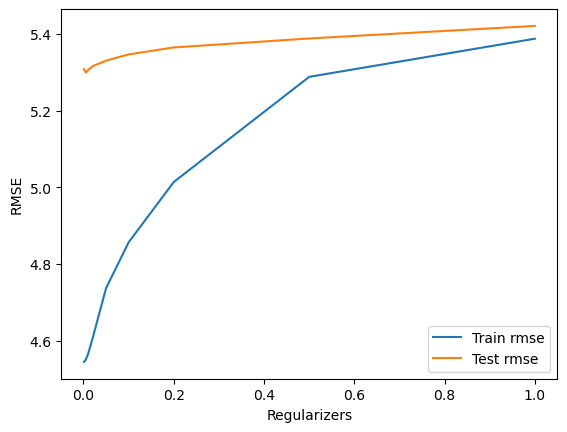

[0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 5, 10, 100]

In [24]:
fig, ax = plt.subplots(1,1)

ax.plot(grid[:9], train_rmses[:9], label='Train rmse')
ax.plot(grid[:9], test_rmses[:9], label='Test rmse')
ax.set_xlabel('Regularizers')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

grid

In [131]:
best_rmse = np.min(test_rmses); best_rmse

0.6561024768356988

In [132]:
best_param = grid[np.argmin(test_rmses)]; best_param

(0.1, 0.1, 0.5, 0.01)

In [127]:
best_rmse = np.min(test_rmses); best_rmse

0.6585922638271475

In [129]:
best_param = grid[np.argmin(test_rmses)]; best_param

0.05

## Getting train and test error for different num of epochs

In [29]:
epochs = [1, 10, 50, 100]
train_rmses = np.zeros(len(epochs))
test_rmses = np.zeros(len(epochs))
trainset_to_test = trainset.build_testset()
for i, n_epoch in enumerate(epochs):
    print(f"Number of epochs: {n_epoch}")
    svd_start_ts = time.time()
    svd = sp.SVD(
        n_factors=150, n_epochs=n_epoch, random_state=42,
        lr_all=0.01, reg_all=0.0,        
                )
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

print(f"All test RMSEs: {test_rmses}")

Number of epochs: 1
RMSE: 5.1876
RMSE: 5.3701
RMSE of SVD: 5.370090642793653
Took 10.713383913040161 seconds.
Number of epochs: 10
RMSE: 4.5829
RMSE: 5.3779
RMSE of SVD: 5.3778637922603165
Took 14.676542043685913 seconds.
Number of epochs: 50
RMSE: 4.5496
RMSE: 5.3600
RMSE of SVD: 5.35997389578649
Took 31.285079956054688 seconds.
Number of epochs: 100
RMSE: 4.5473
RMSE: 5.3574
RMSE of SVD: 5.357363855900846
Took 51.00141382217407 seconds.
All test RMSEs: [5.37009064 5.37786379 5.3599739  5.35736386]


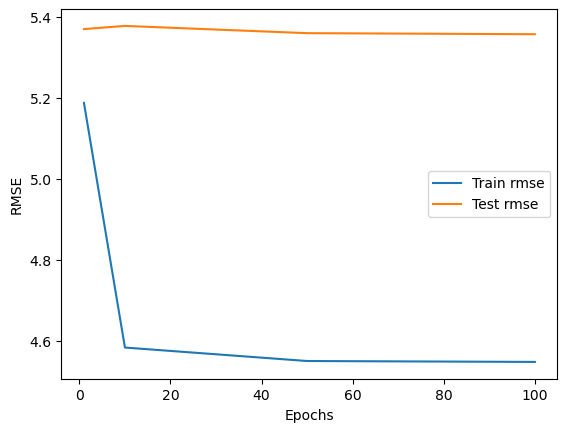

In [30]:
fig, ax = plt.subplots(1,1)

ax.plot(epochs, train_rmses, label='Train rmse')
ax.plot(epochs, test_rmses, label='Test rmse')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

In [27]:
epochs = [1, 10, 50, 100]
train_rmses = np.zeros(len(epochs))
test_rmses = np.zeros(len(epochs))
trainset_to_test = trainset.build_testset()
for i, n_epoch in enumerate(epochs):
    print(f"Number of epochs: {n_epoch}")
    svd_start_ts = time.time()
    svd = sp.SVD(
        n_factors=150, n_epochs=n_epoch, random_state=42,
        lr_all=0.01, reg_all=0.4,        
                )
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

print(f"All test RMSEs: {test_rmses}")

Number of epochs: 1
RMSE: 5.4464
RMSE: 5.4586
RMSE of SVD: 5.45863448490639
Took 10.654633045196533 seconds.
Number of epochs: 10
RMSE: 5.3180
RMSE: 5.3828
RMSE of SVD: 5.382776294211442
Took 13.843350172042847 seconds.
Number of epochs: 50
RMSE: 5.2745
RMSE: 5.3874
RMSE of SVD: 5.387358971746903
Took 30.343273878097534 seconds.
Number of epochs: 100
RMSE: 5.2622
RMSE: 5.3871
RMSE of SVD: 5.38711310738404
Took 51.00759291648865 seconds.
All test RMSEs: [5.45863448 5.38277629 5.38735897 5.38711311]


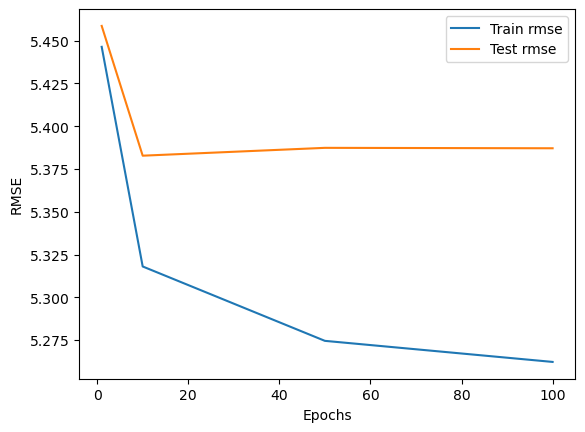

In [28]:
fig, ax = plt.subplots(1,1)

ax.plot(epochs, train_rmses, label='Train rmse')
ax.plot(epochs, test_rmses, label='Test rmse')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

## Training for many different dimensions

In [55]:
dimensions = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400]
train_rmses = np.zeros(len(dimensions))
test_rmses = np.zeros(len(dimensions))
trainset_to_test = trainset.build_testset()
for i, n_factor in enumerate(dimensions):
    print(f"Num features: {n_factor}")
    svd_start_ts = time.time()
    svd = sp.SVD(n_factors=n_factor, n_epochs=50)
    svd.fit(trainset)
    # Report train RMSE 
    train_preds = svd.test(trainset_to_test)
    rmse_train = sp.accuracy.rmse(train_preds)
    # Then report test RMSE
    predictions = svd.test(testset)
    rmse = sp.accuracy.rmse(predictions)
    print(f"RMSE of SVD: {rmse}")
    print(f"Took {time.time() - svd_start_ts} seconds.")
    test_rmses[i] = rmse
    train_rmses[i] = rmse_train

print(f"All test RMSEs: {test_rmses}")

Num features: 1
RMSE: 0.5586
RMSE: 0.6773
RMSE of SVD: 0.6773297186825369
Took 0.5489418506622314 seconds.
Num features: 10
RMSE: 0.4806
RMSE: 0.6734
RMSE of SVD: 0.6734411655777713
Took 0.3321061134338379 seconds.
Num features: 20
RMSE: 0.4365
RMSE: 0.6710
RMSE of SVD: 0.670961176849306
Took 1.944282054901123 seconds.
Num features: 30
RMSE: 0.3942
RMSE: 0.6769
RMSE of SVD: 0.6769142822664116
Took 0.6041898727416992 seconds.
Num features: 40
RMSE: 0.3700
RMSE: 0.6739
RMSE of SVD: 0.6739245852470429
Took 0.710284948348999 seconds.
Num features: 50
RMSE: 0.3410
RMSE: 0.6720
RMSE of SVD: 0.6719969497741214
Took 0.5037150382995605 seconds.
Num features: 60
RMSE: 0.3237
RMSE: 0.6728
RMSE of SVD: 0.6727970217223954
Took 0.43529772758483887 seconds.
Num features: 70
RMSE: 0.3089
RMSE: 0.6762
RMSE of SVD: 0.676212114236966
Took 0.519780158996582 seconds.
Num features: 80
RMSE: 0.2926
RMSE: 0.6784
RMSE of SVD: 0.6784009810357792
Took 0.4868490695953369 seconds.
Num features: 90
RMSE: 0.2792
RMS

In [56]:
test_rmses

array([0.67732972, 0.67344117, 0.67096118, 0.67691428, 0.67392459,
       0.67199695, 0.67279702, 0.67621211, 0.67840098, 0.67602317,
       0.67673239, 0.67846573, 0.68054573, 0.67979523, 0.68292832,
       0.68533196, 0.69401035])

In [57]:
train_rmses

array([0.55855046, 0.48057952, 0.43651077, 0.39424146, 0.3699818 ,
       0.34099951, 0.32371213, 0.30885224, 0.2925758 , 0.27918701,
       0.26635293, 0.22714574, 0.20162524, 0.18359041, 0.17134261,
       0.16156235, 0.15527591])

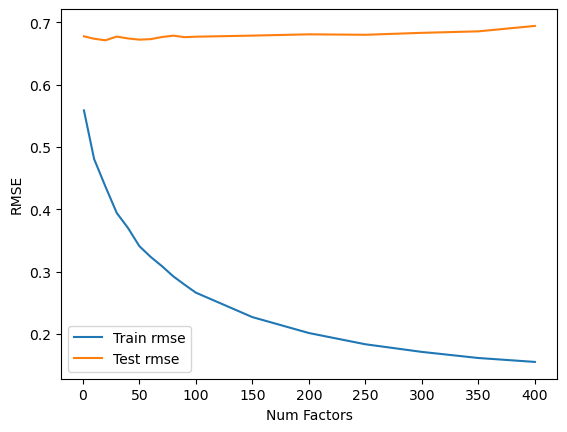

In [58]:
fig, ax = plt.subplots(1,1)

ax.plot(dimensions, train_rmses, label='Train rmse')
ax.plot(dimensions, test_rmses, label='Test rmse')
ax.set_xlabel('Num Factors')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()

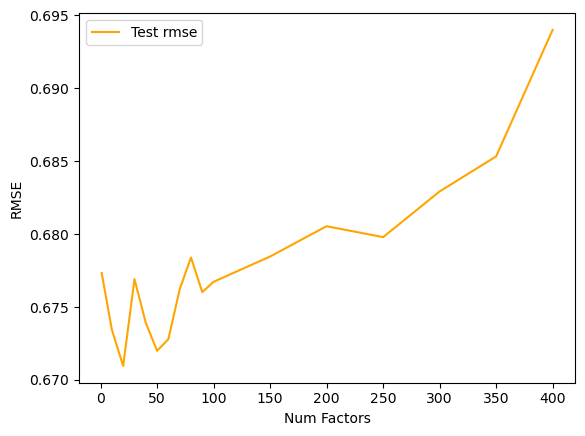

In [61]:
fig, ax = plt.subplots(1,1)

ax.plot(dimensions, test_rmses, label='Test rmse', color='orange')
ax.set_xlabel('Num Factors')
ax.set_ylabel('RMSE')

ax.legend()
plt.show()